# Time Series Analysis
Using Kaggle Dataset Ace Smart Wayter Analytics

In [ ]:
!gdown 1hcb5SNfoy8t_8tmMTBtv5YuV1eMIVTas

Downloading...
From: https://drive.google.com/uc?id=1hcb5SNfoy8t_8tmMTBtv5YuV1eMIVTas
To: /content/Aquifer_Petrignano.csv
100% 262k/262k [00:00<00:00, 80.2MB/s]


In [ ]:
!pip install colorama

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

In [ ]:
df = pd.read_csv('/content/Aquifer_Petrignano.csv')
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [ ]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [ ]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]


In [ ]:
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [ ]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.head().style.set_properties(subset=['date'],**{'background-color': 'blue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


## 1. Data Visualization

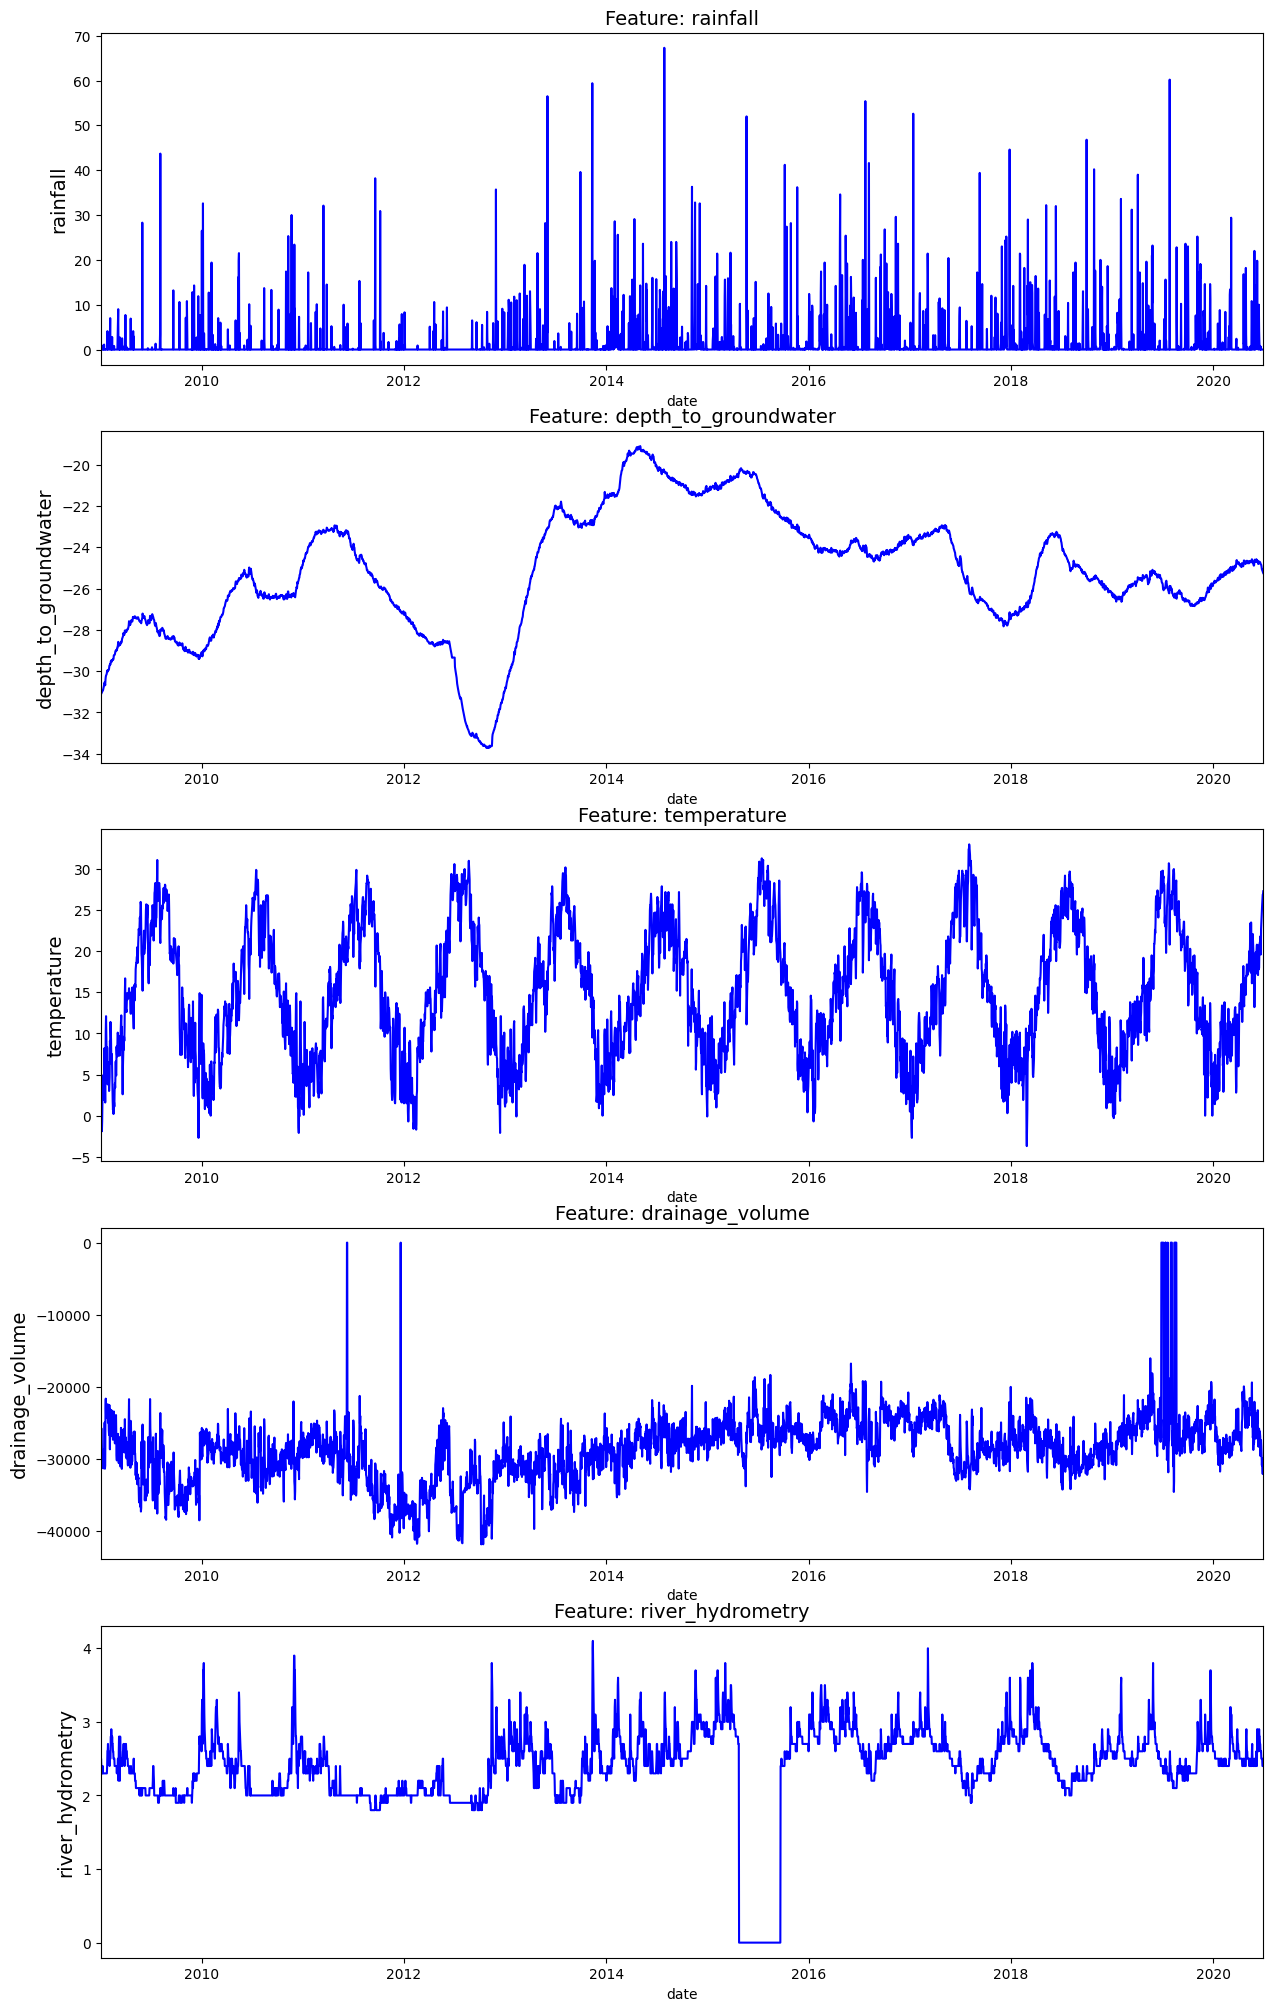

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
  sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='b')
  ax[i].set_title('Feature: {}'.format(column), fontsize=14)
  ax[i].set_ylabel(ylabel=column, fontsize=14)
  ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

## 2. Data Preprocessing

### Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series.

1. Sort the DataFrame by the timestamps.
2. Check if the timestamps are at constant intervals. If not, choose a constant time interval and resample the data.

In [ ]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [ ]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

### 2.1 Handle Missing Value

In [ ]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

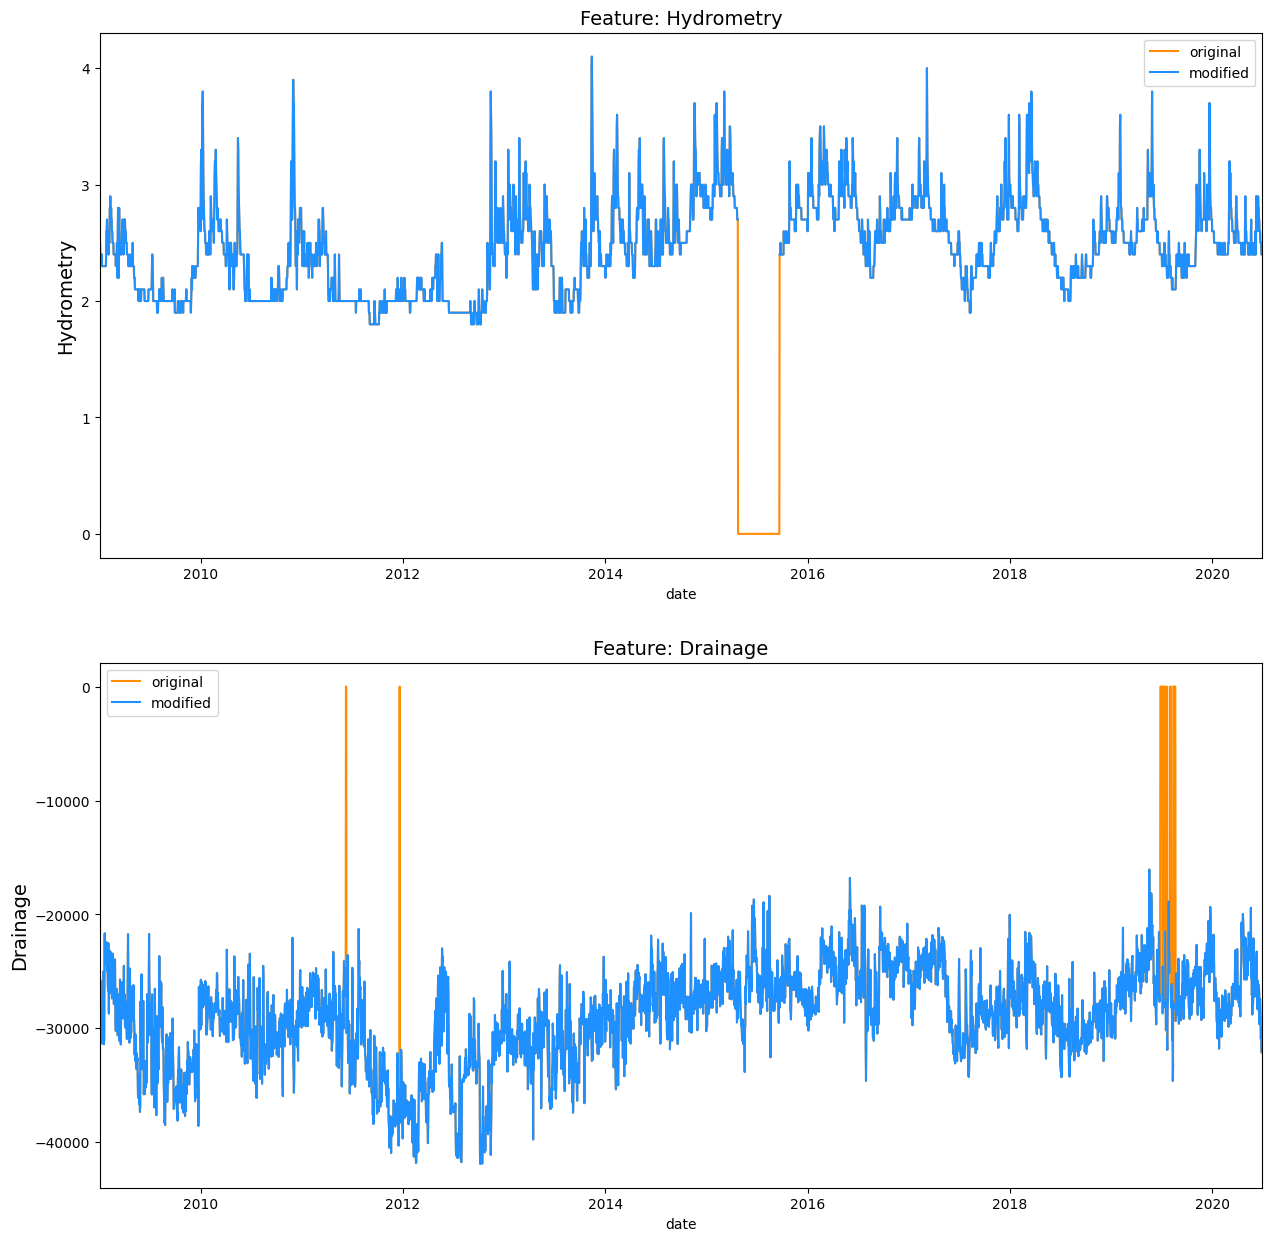

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
ax[0].plot(df['date'], df['river_hydrometry'].fillna(np.inf), color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel('Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[0].legend()

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
ax[1].plot(df['date'], df['drainage_volume'].fillna(np.inf), color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel('Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].legend()

plt.show()

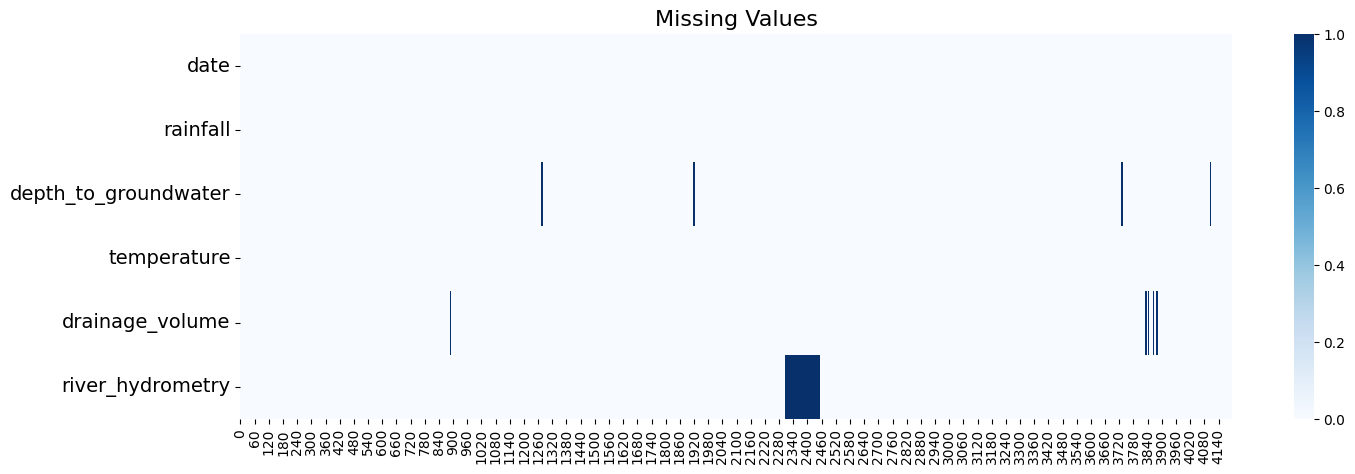

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(14)
plt.show()

1. Fill NaN with outlier or zero
2. Fill NaN with mean value
3. Fill Nan with last value with .ffil()
4. Fill NaN with linearly interpolated value with .interpolate()

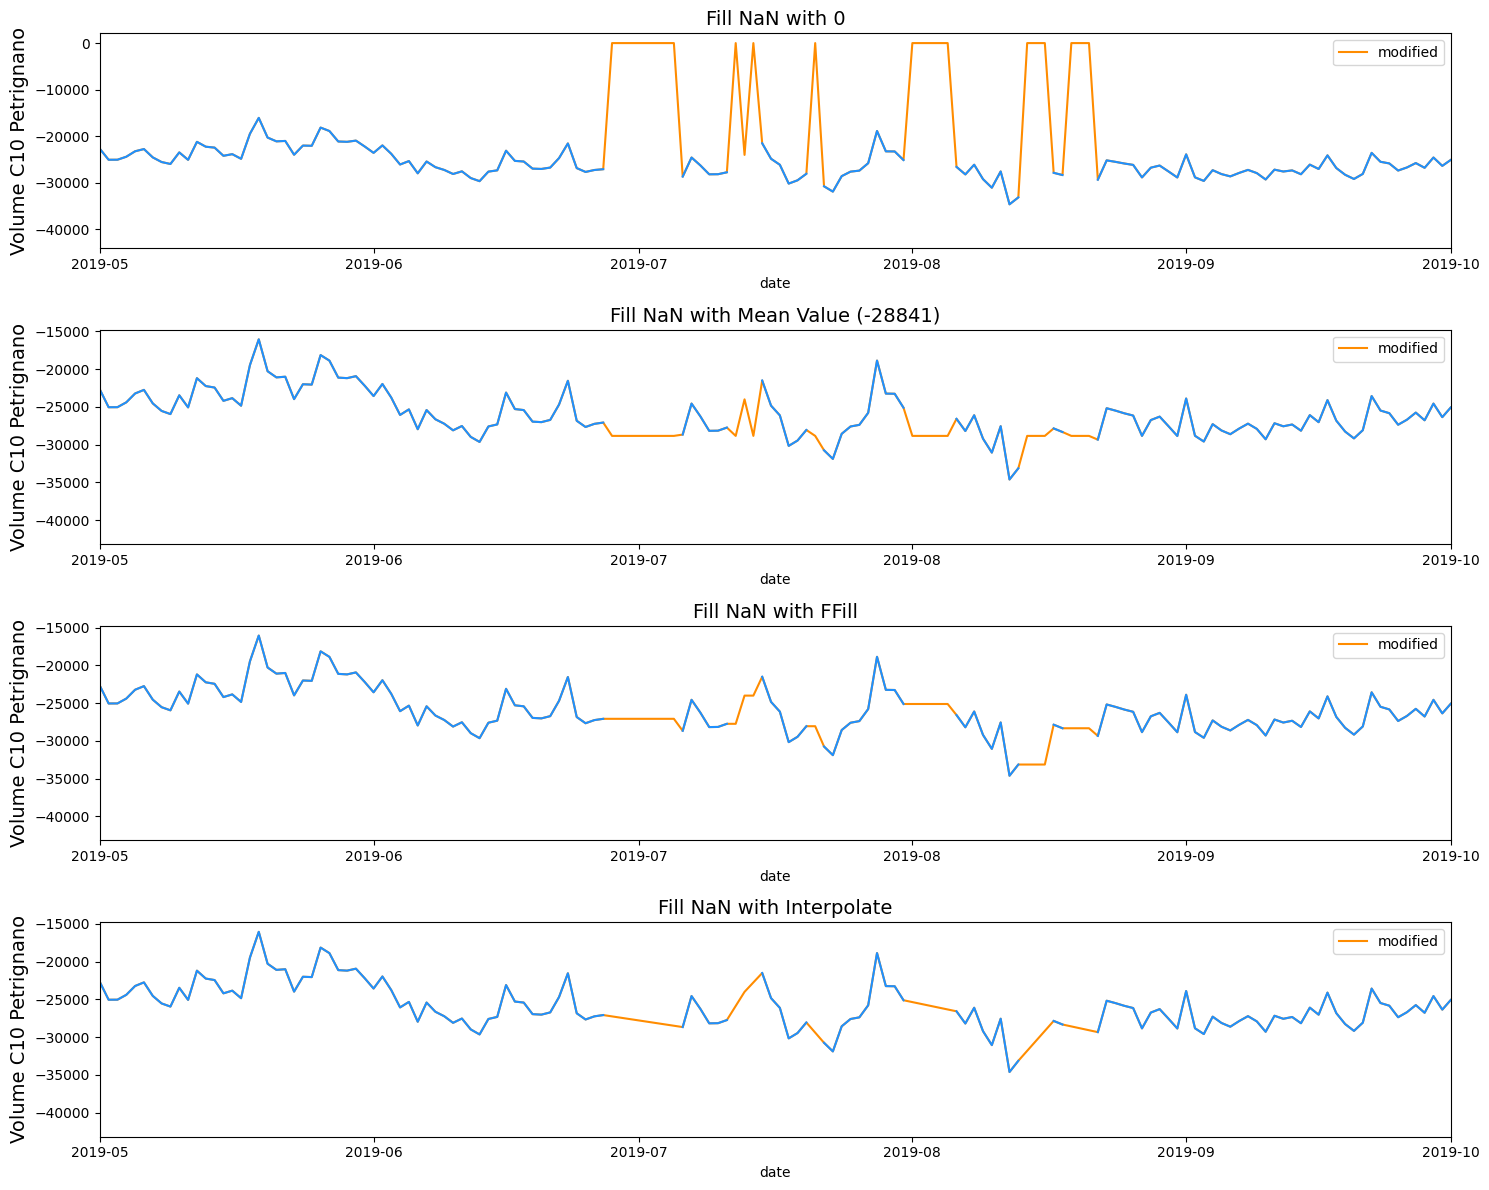

In [ ]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

# Fill NaN with 0
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label='modified')
ax[0].plot(df['date'], df['drainage_volume'], color='dodgerblue', label='original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel('Volume C10 Petrignano', fontsize=14)

# Fill NaN with Mean Value
mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label='modified')
ax[1].plot(df['date'], df['drainage_volume'], color='dodgerblue', label='original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel('Volume C10 Petrignano', fontsize=14)

# FFill
sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label='modified')
ax[2].plot(df['date'], df['drainage_volume'], color='dodgerblue', label='original')
ax[2].set_title('Fill NaN with FFill', fontsize=14)
ax[2].set_ylabel('Volume C10 Petrignano', fontsize=14)

# Interpolate
sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label='modified')
ax[3].plot(df['date'], df['drainage_volume'], color='dodgerblue', label='original')
ax[3].set_title('Fill NaN with Interpolate', fontsize=14)
ax[3].set_ylabel('Volume C10 Petrignano', fontsize=14)

# Set x-axis limits
for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

plt.tight_layout()
plt.show()

We can see from these graph that interpolate seems to be the best option

In [ ]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

### 2.2 Smoothing data / Resampling

* Upsampling is when the frequency of samples is increased (e.g. days to hours)

* Downsampling is when the frequency of samples is decreased (e.g. days to weeks)

We will be doing some downsampling with the .resample() function (similar to groupby and aggregate as mean).

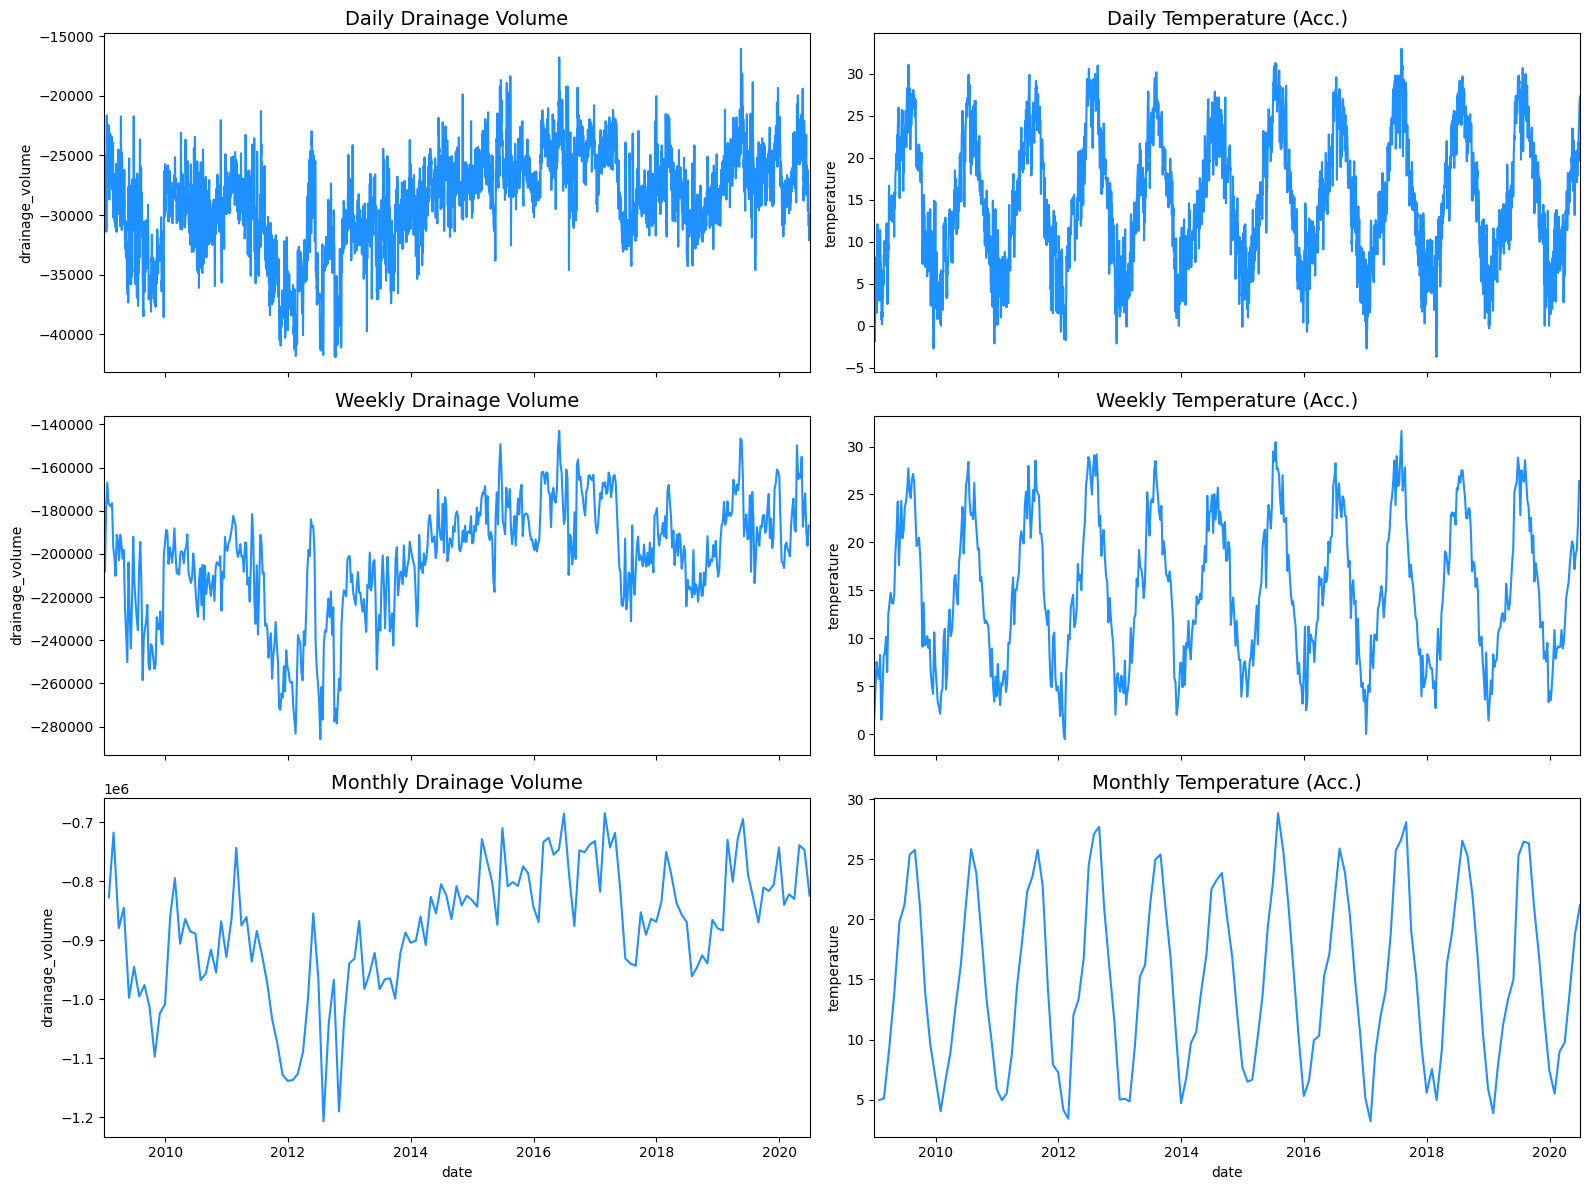

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

# Daily Drainage Volume
sns.lineplot(x='date', y='drainage_volume', data=df, color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Daily Drainage Volume', fontsize=14)

# Weekly Drainage Volume
resampled_df = df[['date', 'drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x='date', y='drainage_volume', data=resampled_df, color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

# Monthly Drainage Volume
resampled_df = df[['date', 'drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x='date', y='drainage_volume', data=resampled_df, color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Daily Temperature
sns.lineplot(x='date', y='temperature', data=df, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

# Weekly Temperature
resampled_df = df[['date', 'temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x='date', y='temperature', data=resampled_df, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

# Monthly Temperature
resampled_df = df[['date', 'temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x='date', y='temperature', data=resampled_df, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

As we can see, downsample to weekly could smooth the data and help with analysis

In [ ]:
downsample = df[['date',
                 'depth_to_groundwater',
                 'temperature',
                 'drainage_volume',
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()
df.head()

,date,depth_to_groundwater,temperature,drainage_volume,river_hydrometry,rainfall
0,2009-01-01,-31.048571,1.657143,-28164.918857,2.371429,0.000000
1,2009-01-08,-30.784286,4.571429,-29755.789714,2.314286,0.285714
2,2009-01-15,-30.420000,7.528571,-25463.190857,2.300000,0.028571
3,2009-01-22,-30.018571,6.214286,-23854.422857,2.500000,0.585714
4,2009-01-29,-29.790000,5.771429,-25210.532571,2.500000,1.414286


### 2.3 Stationarity

Stationarity describes that the time-series has

* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

To check stationarity, we can use 3 different approaches:
1. visually: plot time series and check for trends or seasonality
2. basic statistics: split time series and compare the mean and variance of each partition
3. statistical test: Augmented Dickey Fuller test

A year has 52 weeks (52 weeks * 7 days per week).

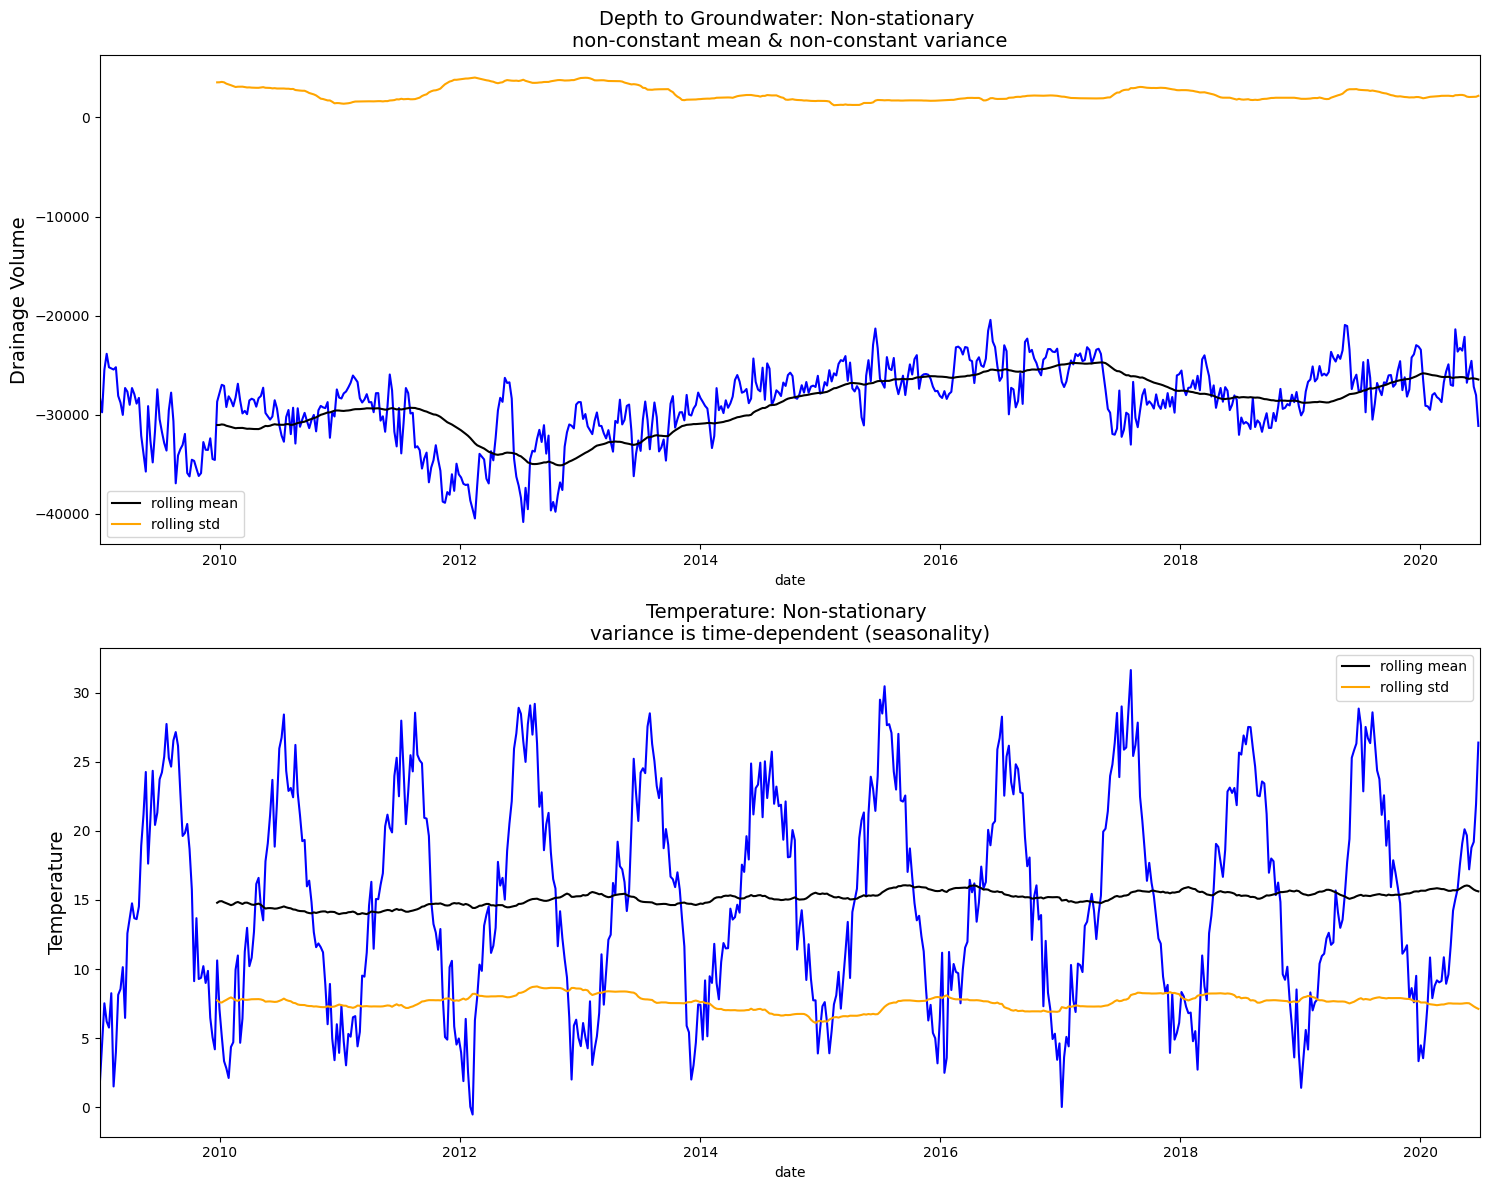

In [ ]:
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='b')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(),
             ax=ax[0], color='k', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(),
             ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='b')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(),
             ax=ax[1], color='k', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(),
             ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In this visual check, we can see that the features don't have constant mean and std, but they are close to it.

#### Unit Root Test
Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

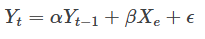

where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

The presence of a unit root means the time series is non-stationary.

### 2.3.2 Augmented Dickey-Fuller (ADF)

The Augmented Dickey-Fuller (ADF) test is a statistical test used to check if a time series is stationary or not. Stationarity means that the statistical properties of the series, like mean and variance, do not change over time. Non-stationary data can have trends, cycles, or other structures that change over time, making it harder to model and forecast.

1. Hypotheses
* Null Hypothesis (H0): The time series has a unit root, meaning it is non-stationary.
* Alternative Hypothesis (H1): The time series does not have a unit root, meaning it is stationary.

2. Interpreting the Results

There are two main ways to decide if we can reject the null hypothesis (H0):

a) Using the p-value:

* p-value > significance level (default: 0.05): Fail to reject the null hypothesis. This means the data has a unit root and is non-stationary.
* p-value ≤ significance level (default: 0.05): Reject the null hypothesis. This means the data does not have a unit root and is stationary.

b) Using the ADF statistic and critical value:

* ADF statistic > critical value: Fail to reject the null hypothesis. The data has a unit root and is non-stationary.
* ADF statistic < critical value: Reject the null hypothesis. The data does not have a unit root and is stationary.

3. Summary
* If either the p-value is less than or equal to the significance level (usually 0.05), or the ADF statistic is less than the critical value, we can conclude that the time series is stationary.
* If the p-value is greater than the significance level, or the ADF statistic is greater than the critical value, we conclude that the time series is non-stationary.


In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.8802016493166605,
 0.047699190920208856,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

As we can see, the p-value is less than 0.05. Now, check the range of the ADF statistic compared with critical_values

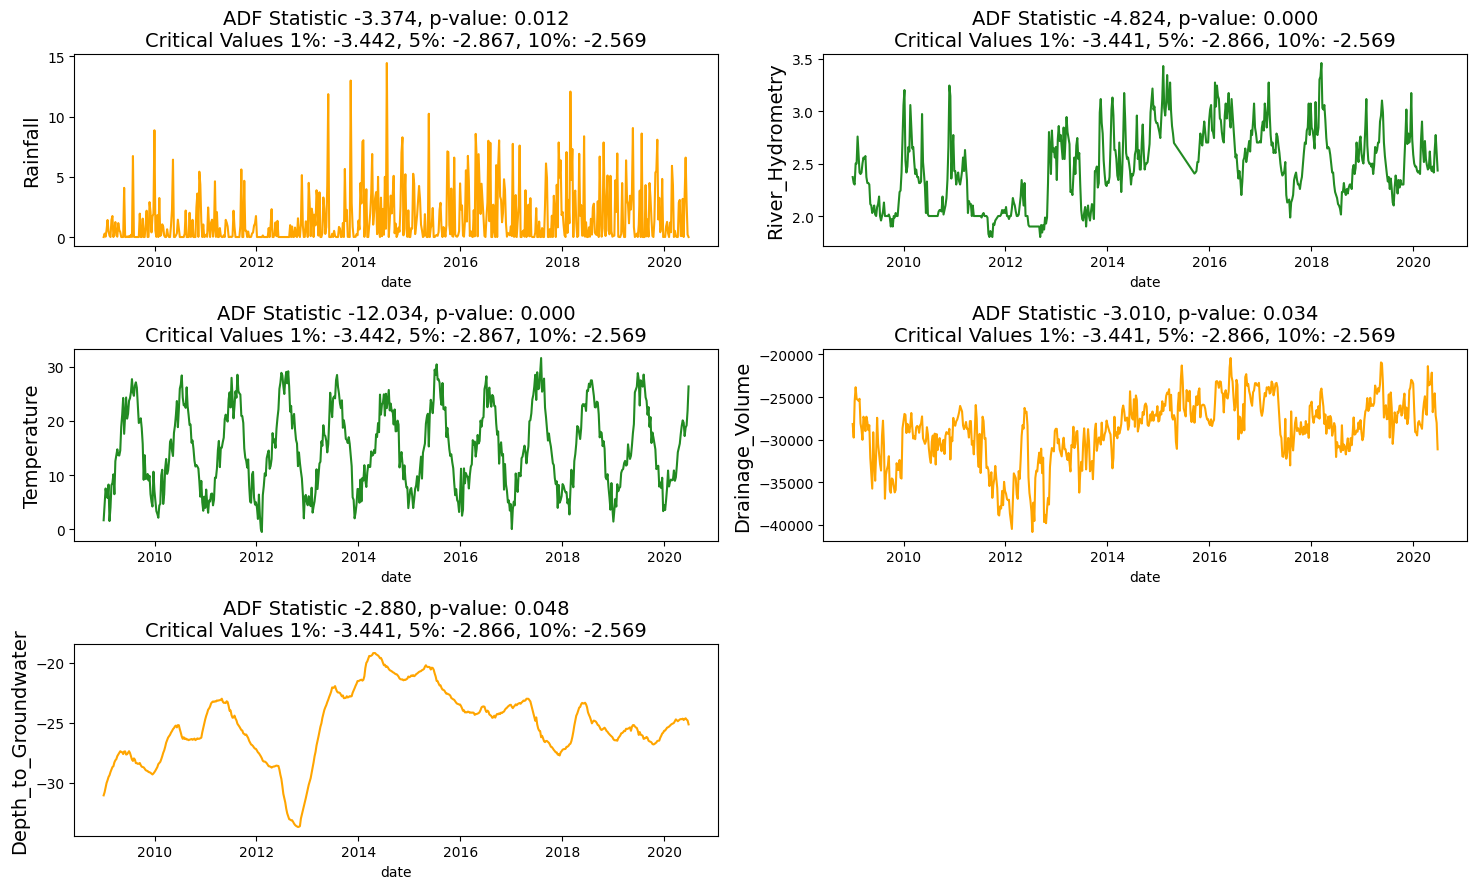

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

* Transformation: e.g. log or square root to stabilize non-constant variance
* Differencing: subtracts the current value from the previous

### 2.3.2 Transforming

<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

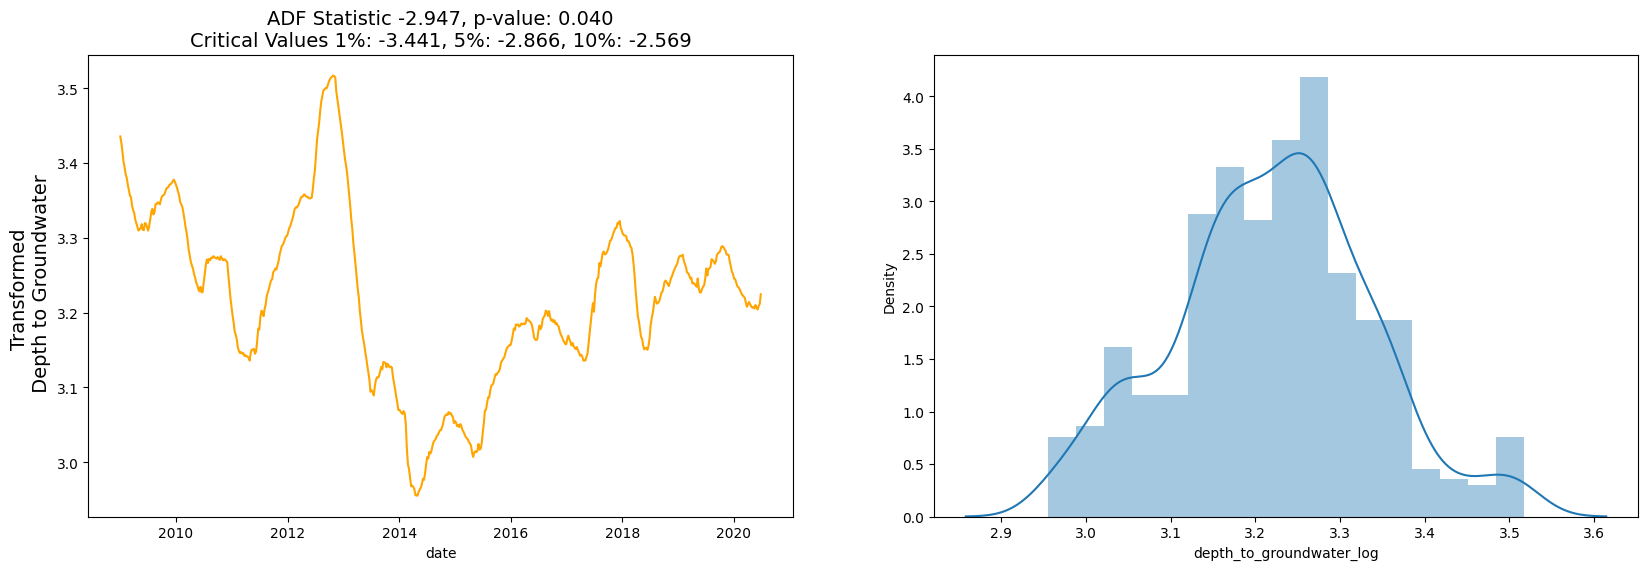

In [ ]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(1, 2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'],
                           'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

Differencing can be done in different orders:
* First order differencing : linear trends with image.png
* Second-order differencing: quadratic trends with image.png
* and so on

### 2.3.3 Differencing

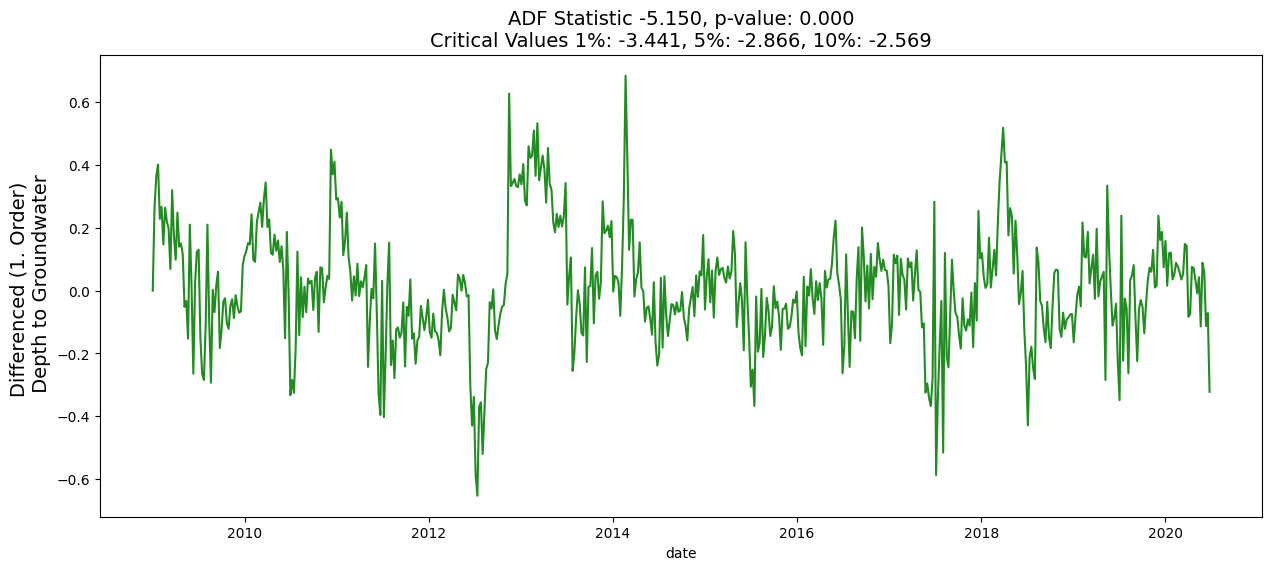

In [ ]:
# Fist Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(1, 1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

### 3. Feature engineering

In [ ]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()


,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


### 3.1 Encoding Cyclical Features

Cyclical time features, such as the month of the year, repeat in a regular pattern. For example, the month feature cycles from 1 (January) to 12 (December) every year. This cycling can create challenges when used in models because of how the differences between values are interpreted.

####Example:
* During a single year, the month feature increases sequentially: January (1), February (2), March (3), and so on, up to December (12).
* At the end of the year, the month feature jumps from December (12) back to January (1).

####Problem with Differences:
* For months within the same year, the difference between consecutive months is always 1.
* However, when moving from December to January, the difference is -11 (1 - 12).

This sudden large negative jump can confuse models because it doesn't reflect the true cyclical nature of the data. Models might interpret this as a significant change, when in reality, it's just the start of a new cycle.

####Why It's Important:

* Many models assume that the difference between consecutive values is consistent.
* The -11 difference at the year boundary can lead to incorrect interpretations and predictions.

####Solution:

To handle cyclical features properly, we can transform them using sine and cosine functions. This transformation maintains the cyclical nature and ensures smooth transitions between the end and start of the cycle.

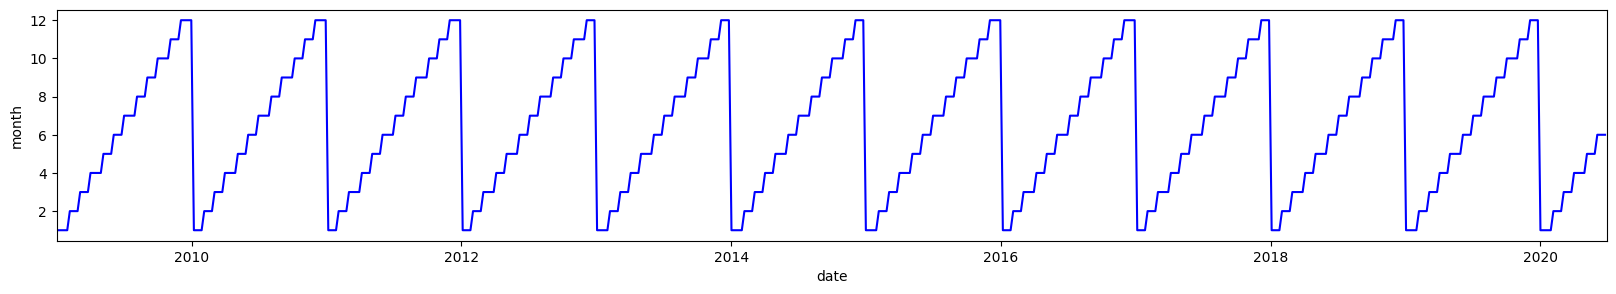

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='b')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

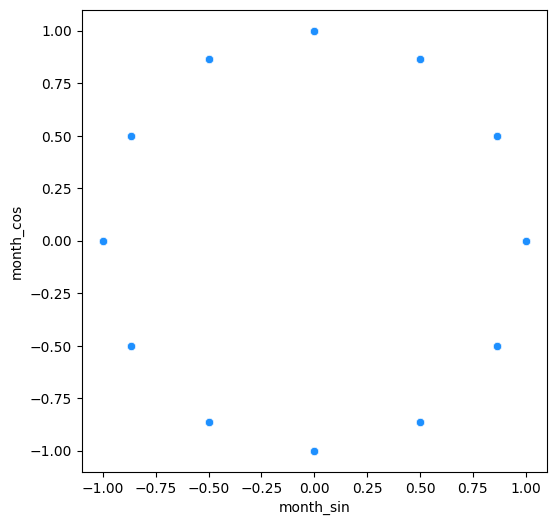

In [ ]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

###3.2 Time Series Decomposition
Time series decomposition is a method used to break down a time series into its fundamental components.

These components help in understanding the underlying patterns and behaviors in the data. The main components are:

1. Level: The baseline or average value in the series.
2. Trend: The overall direction in which the series is moving, whether it’s increasing or decreasing over time.
3. Seasonality: The repeating short-term patterns in the series, such as monthly or yearly cycles.
4. Noise: The random variation in the series that cannot be attributed to the level, trend, or seasonality.

####Why Decomposition is Useful
Decomposing a time series provides a clear and abstract model for understanding the data. It helps in identifying and analyzing the different components, which can be crucial for accurate forecasting and analysis.

####Components of Time Series
* Level and Noise: All time series have these components.
* Trend and Seasonality: These are optional and may or may not be present in the series.

####Types of Decomposition
There are two main ways to combine these components:

1. Additive Model:

The components are added together.
Equation:
𝑦
(
𝑡
)
=
Level
+
Trend
+
Seasonality
+
Noise
y(t)=Level+Trend+Seasonality+Noise

2. Multiplicative Model:

The components are multiplied together.
Equation:
𝑦
(
𝑡
)
=
Level
×
Trend
×
Seasonality
×
Noise
y(t)=Level×Trend×Seasonality×Noise

####Practical Application
To perform time series decomposition, we can use the seasonal_decompose() function from the statsmodels library in Python. This function helps in breaking down the series into its components, making it easier to analyze and understand.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns = [
    'rainfall', 'temperature', 'drainage_volume',
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
  decomp = seasonal_decompose(df[column], period=52,
                              model='additive', extrapolate_trend='freq')
  df[f"{column}_trend"] = decomp.trend
  df[f"{column}_seasonal"] = decomp.seasonal

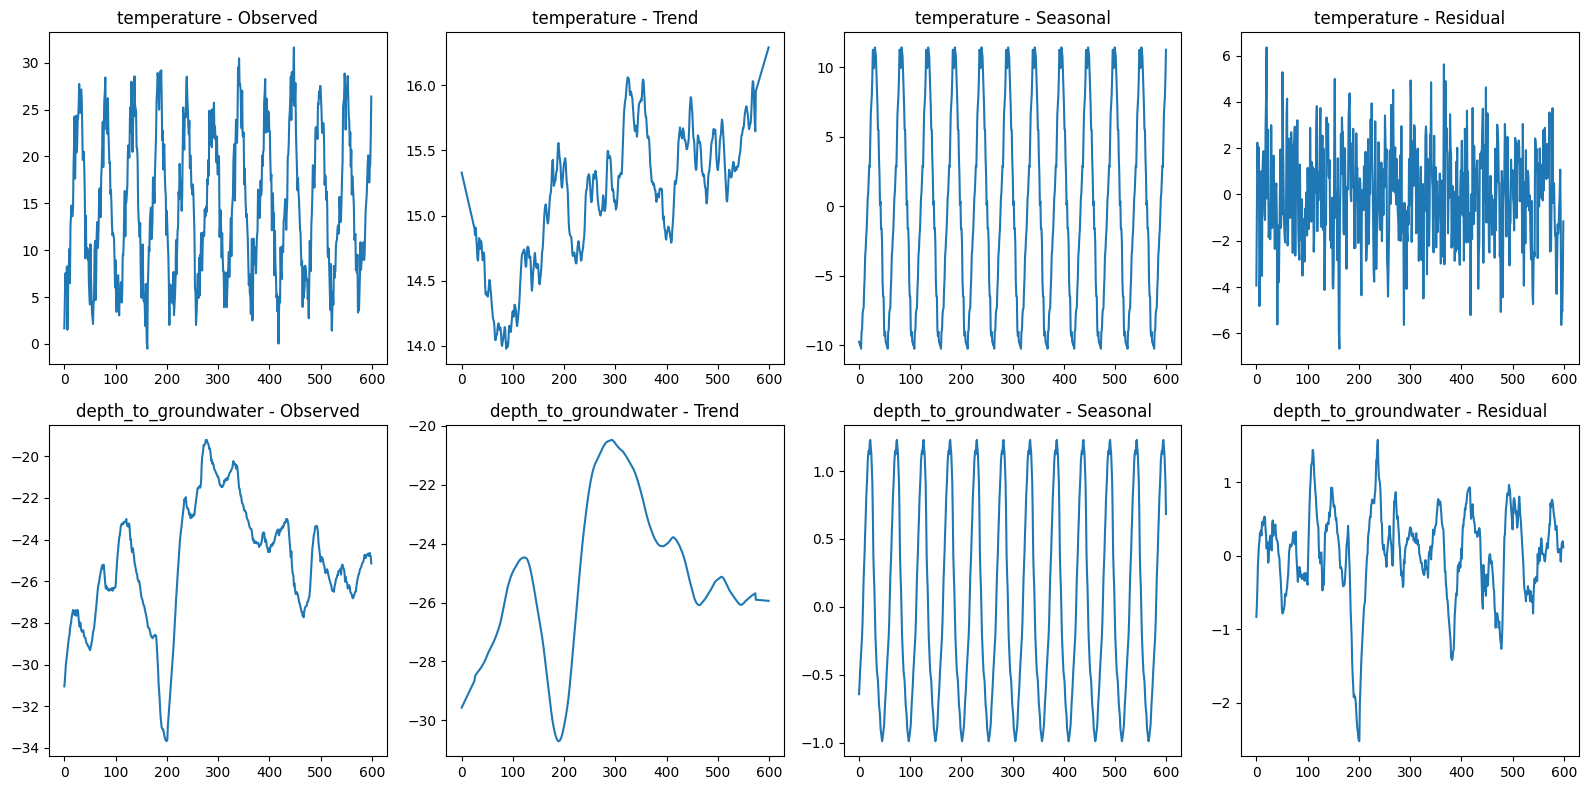

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    # Plot observed
    ax[i, 0].plot(res.observed)
    ax[i, 0].set_title(f'{column} - Observed')

    # Plot trend
    ax[i, 1].plot(res.trend)
    ax[i, 1].set_title(f'{column} - Trend')

    # Plot seasonal
    ax[i, 2].plot(res.seasonal)
    ax[i, 2].set_title(f'{column} - Seasonal')

    # Plot residual
    ax[i, 3].plot(res.resid)
    ax[i, 3].set_title(f'{column} - Residual')

plt.tight_layout()
plt.show()

### 3.3 Lag
We want to calculate each variable with a shift() (lag) to compare the correlation with the other variables.

In [ ]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

### 4. Exploratory Data Analysis

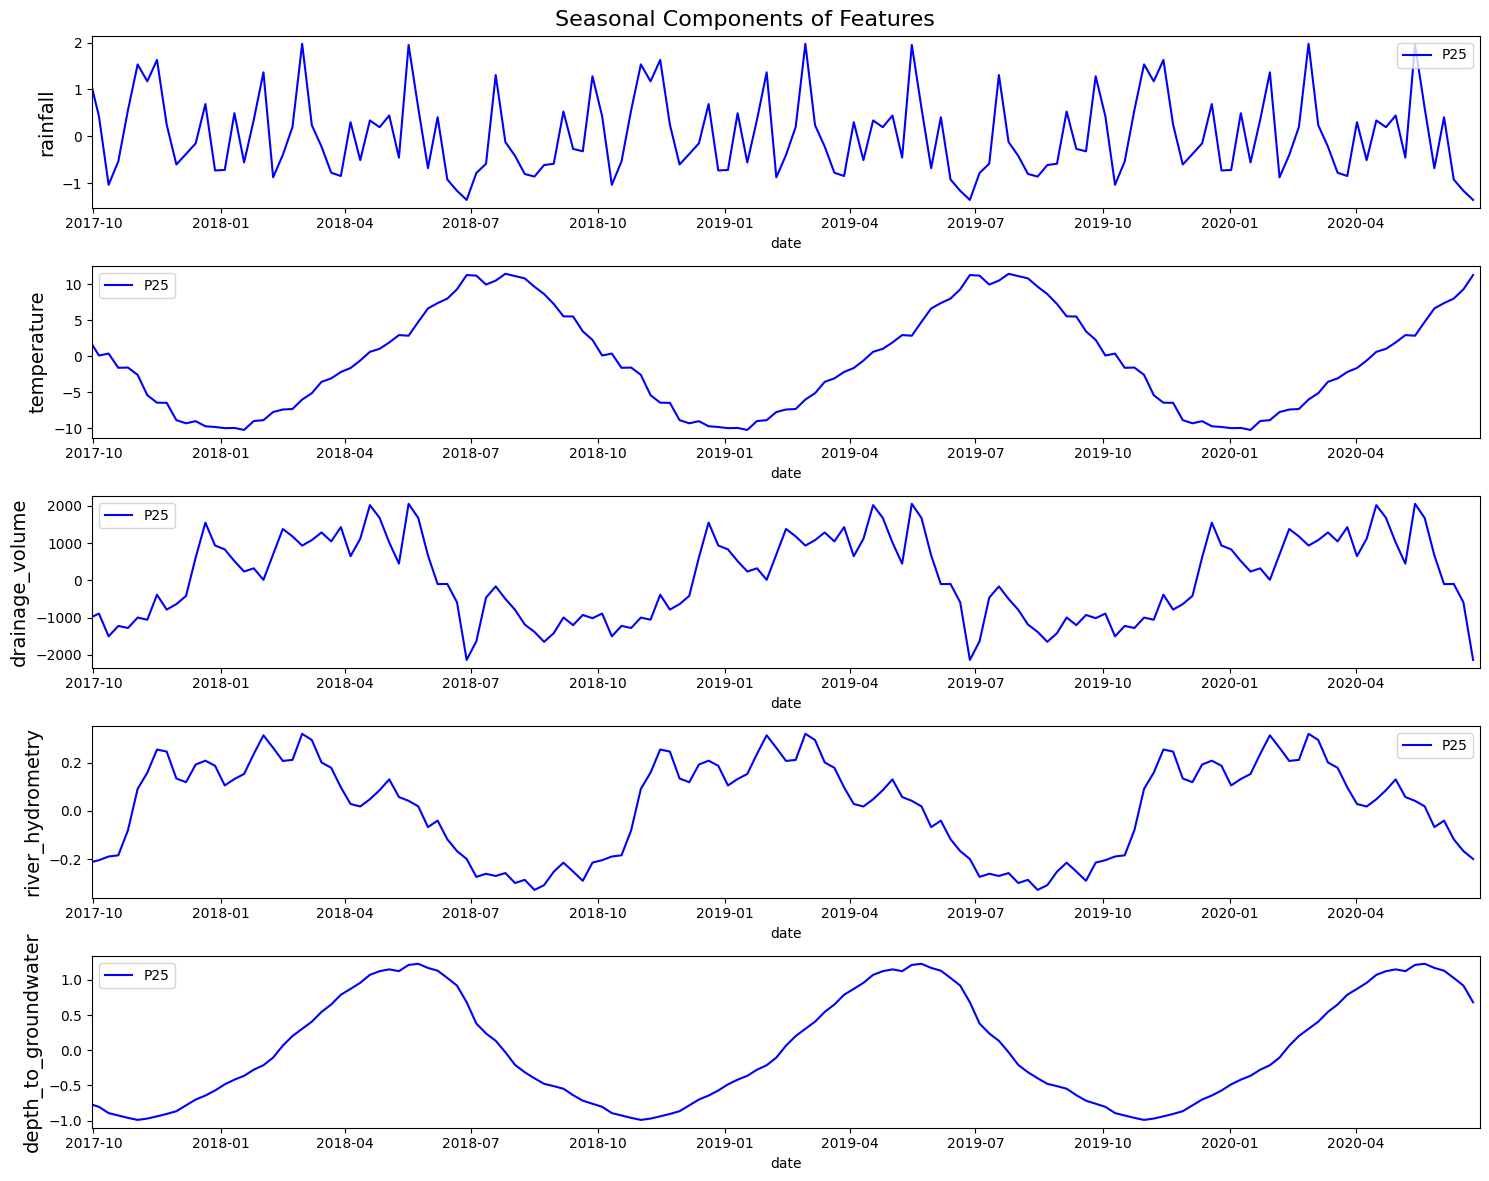

In [ ]:
f, ax = plt.subplots(5, 1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
  sns.lineplot(x=df['date'], y=df[column + '_seasonal'],
               ax=ax[i], color='b', label='P25')
  ax[i].set_ylabel(ylabel=column, fontsize=14)
  ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

* `depth_to_groundwater`: reaches its maximum around May/June and its minimum around November
* `temperature`: reaches its maxmium around August and its minimum around January
* `drainage_volume`: reaches its minimum around July.
* `river_hydrometry`: reaches its maximum around February/March and its minimum around September

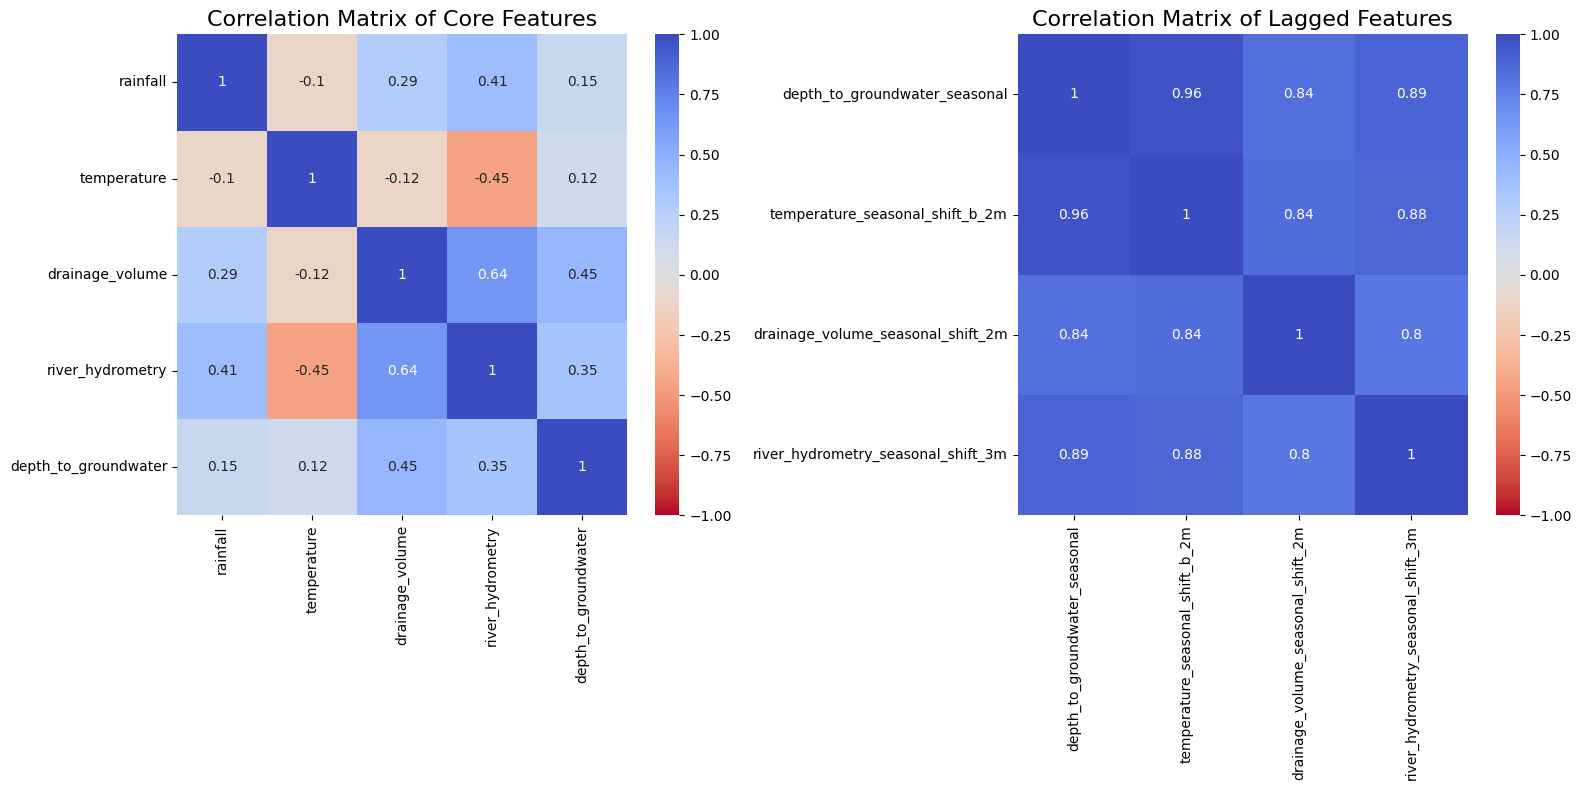

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m',
    'river_hydrometry_seasonal_shift_3m'
]

corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)

plt.tight_layout()
plt.show()

### 4.1 Autocorrelation Analysis

#### ACF and PACF Plots:

After making a time series stationary by differencing, the next step in fitting an ARIMA model is to determine the necessity of AR (AutoRegressive) or MA (Moving Average) terms to correct any remaining autocorrelation in the differenced series. While software like Statgraphics allows you to try various combinations of terms and see which works best, a more systematic approach involves examining the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the differenced series. These plots help in tentatively identifying the number of AR and/or MA terms needed.

####Autocorrelation Function (ACF):

* P (Periods to lag): For example, if P=3, the three previous periods of the time series are used in the autoregressive portion of the calculation. P helps adjust the line fitted to forecast the series and corresponds with the MA parameter.

####Partial Autocorrelation Function (PACF):

* D (Differencing): In an ARIMA model, differencing is used to transform a time series into a stationary one (a series without trend or seasonality). D refers to the number of differencing transformations required to make the series stationary and corresponds with the AR parameter.

####Detecting Seasonality:

* Autocorrelation plots are useful for detecting seasonality in the data.

By analyzing the ACF and PACF plots, you can systematically determine the appropriate AR and MA terms for your ARIMA model.

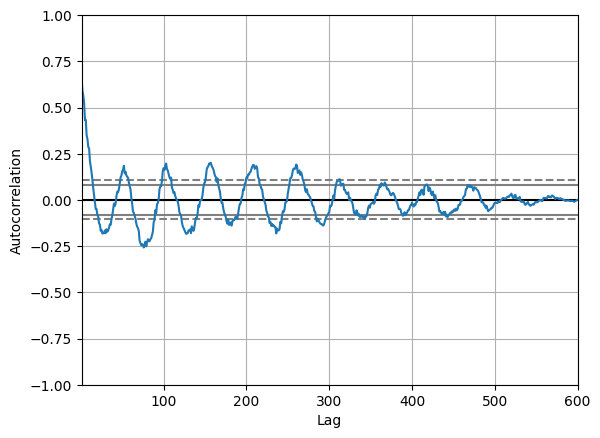

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

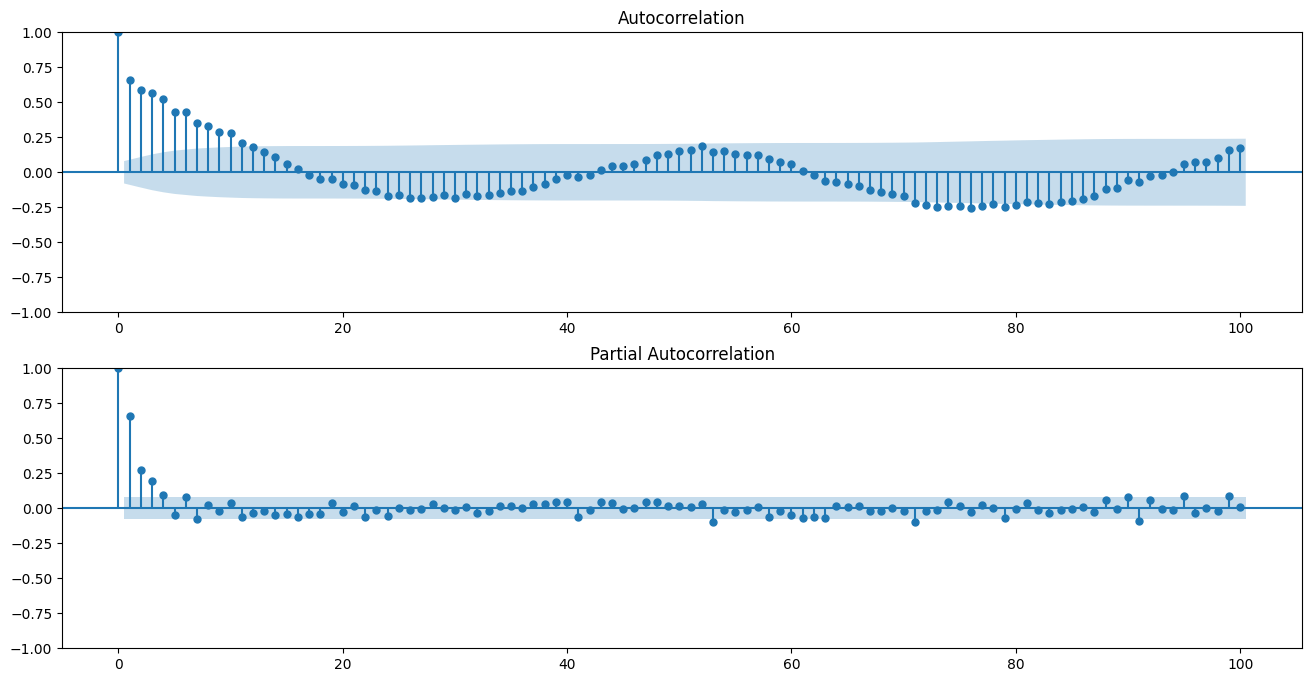

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

### 5. Modelling
Time series data can be either univariate or multivariate:

* Univariate Time Series: This type has only a single time-dependent variable.
* Multivariate Time Series: This type has multiple time-dependent variables.

Before diving into modeling, let's first understand how cross-validation works in time series analysis

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

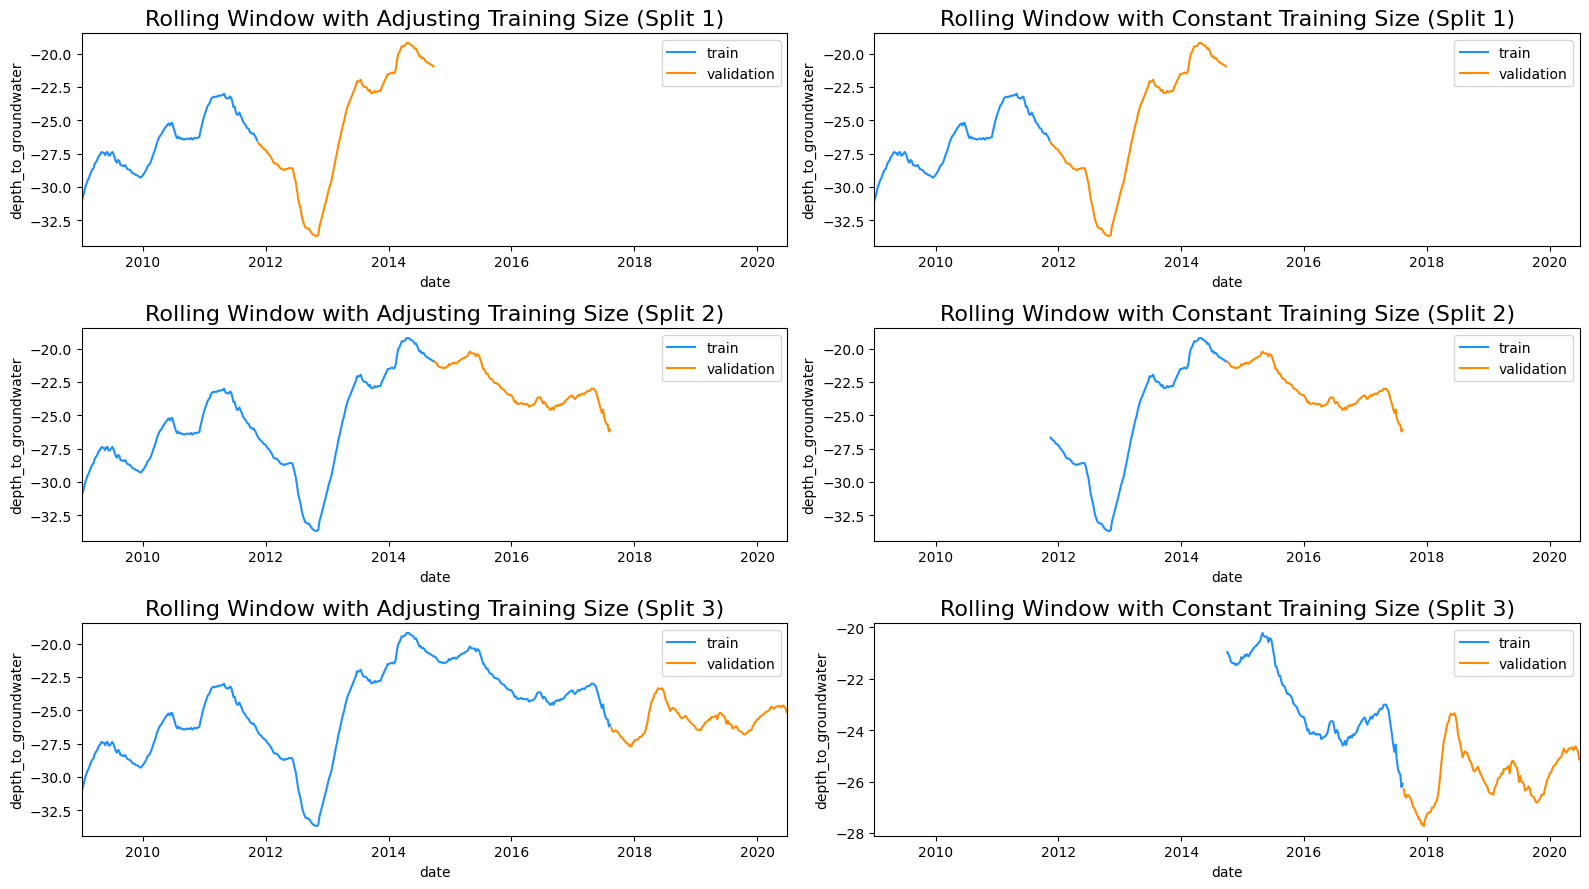

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i,0],
        color='dodgerblue',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        ax=ax[i,1],
        color='dodgerblue',
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

### 5.1 Models for Univariate Time Analysis
Univariate time series: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [ ]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


### 5.1.1 ARIMA
The ARIMA model describes the autocorrelations in the data, assuming the time series is stationary. It consists of three main parts:

1. Auto-Regressive (AR) Filter (Long Term):
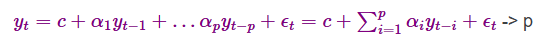

p: Number of lag observations (references the PACF in Autocorrelation Analysis).

2. Integration Filter (Stochastic Trend):

d: Degree of differencing to make the series stationary (references Differencing in Stationarity).

3. Moving Average (MA) Filter (Short Term):
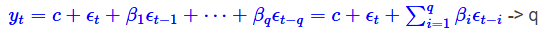
q: Order of moving average (references the ACF in Autocorrelation Analysis).
The ARIMA model combines these components:
 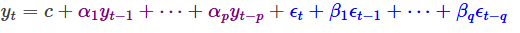
ARIMA is represented as ARIMA(p, d, q).

* p: Lag order (from PACF).
* d: Degree of differencing (to achieve stationarity).
* q: Order of moving average (from ACF).

#### Steps to Analyze ARIMA:

1. Check Stationarity: If a time series has a trend or seasonality, it must be made stationary before using ARIMA for forecasting.

2. Difference the Series: If the series is not stationary, use differencing to stationarize it. Take the first difference and check for stationarity. Repeat as needed, including seasonal differencing if necessary.

3. Filter Out a Validation Sample: Use a validation sample to check the accuracy of the model. Split the data into training and test sets.

4. Select AR and MA Terms: Use ACF and PACF plots to determine whether to include AR terms, MA terms, or both.

5. Build the Model: Build the ARIMA model and set the forecast period based on your needs.

6. Validate the Model: Compare the predicted values to the actual values in the validation sample to assess accuracy.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model
# Use the updated ARIMA class
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(90)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 1.402615843711107


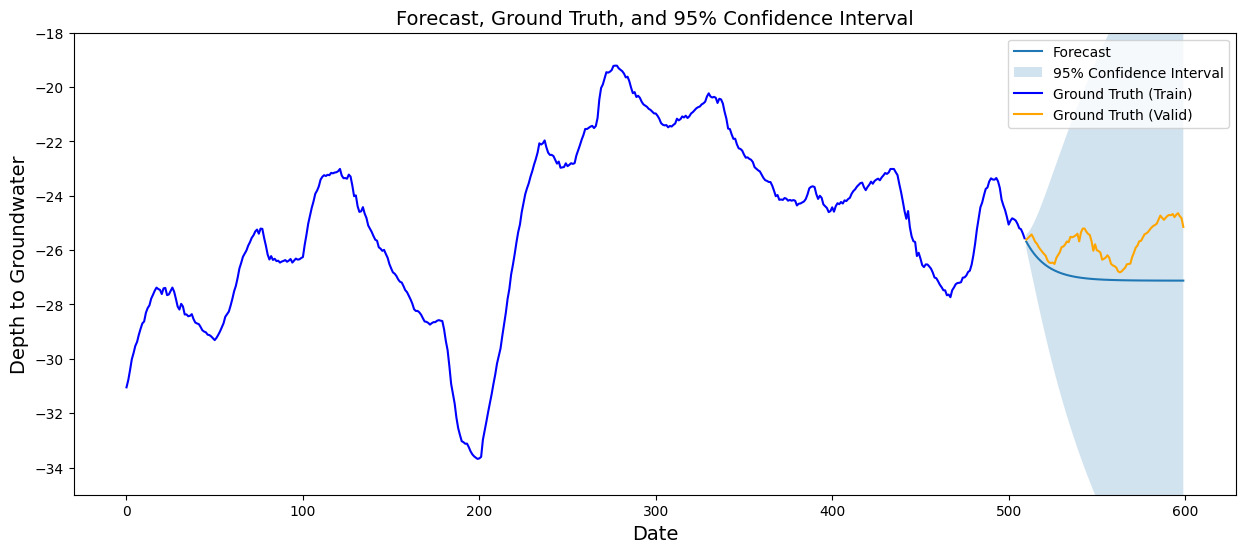

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# Get forecast and confidence intervals
forecast = model_fit.get_forecast(steps=90)  # Adjust steps as needed
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Plot forecast and confidence intervals
ax.plot(forecast_mean, label='Forecast')
ax.fill_between(forecast_conf_int.index,
                forecast_conf_int.iloc[:, 0],
                forecast_conf_int.iloc[:, 1],
                alpha=0.2, label='95% Confidence Interval')

# Plot ground truth (training data)
sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax, color='blue', label='Ground Truth (Train)')

# Plot ground truth (validation data) - if available
if 'y_valid' in locals():
    sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground Truth (Valid)')

ax.set_title(f'Forecast, Ground Truth, and 95% Confidence Interval', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

ax.set_ylim(-35, -18)  # Adjust y-axis limits as needed
plt.legend()
plt.show()

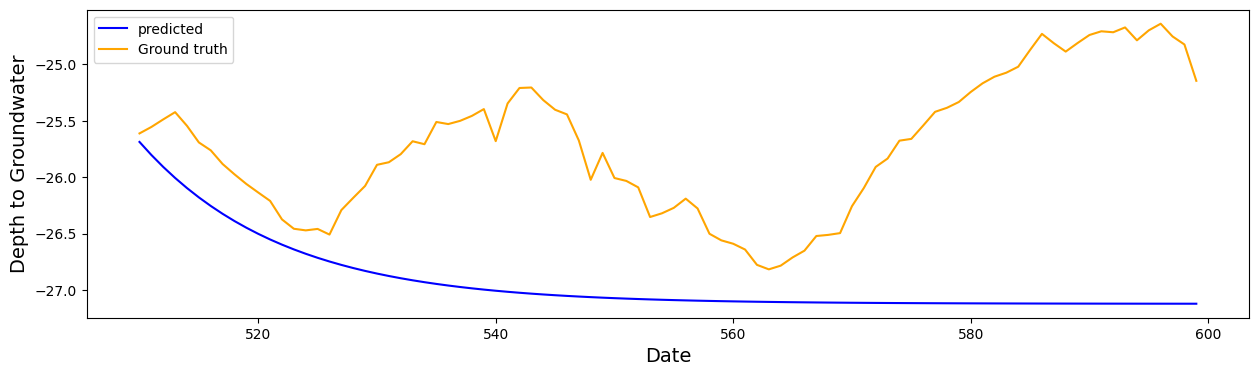

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

### 5.1.2 Auto-ARIMA


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.0 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                     test='adf', # use adftest to find optimal 'd'
                     max_p=3, max_q=3,
                     m=1, # frequency of series
                     d=None, # let model determine 'd'
                     seasonal=False, # let model determine 'd'
                     start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True
                     )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=1.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=1.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=2.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=2.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.76 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=3.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=1.96 sec
 ARIMA(1,1,2)(0,0,0)[0]          

As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (1,1,1) is the best configuration for (p,d,q).

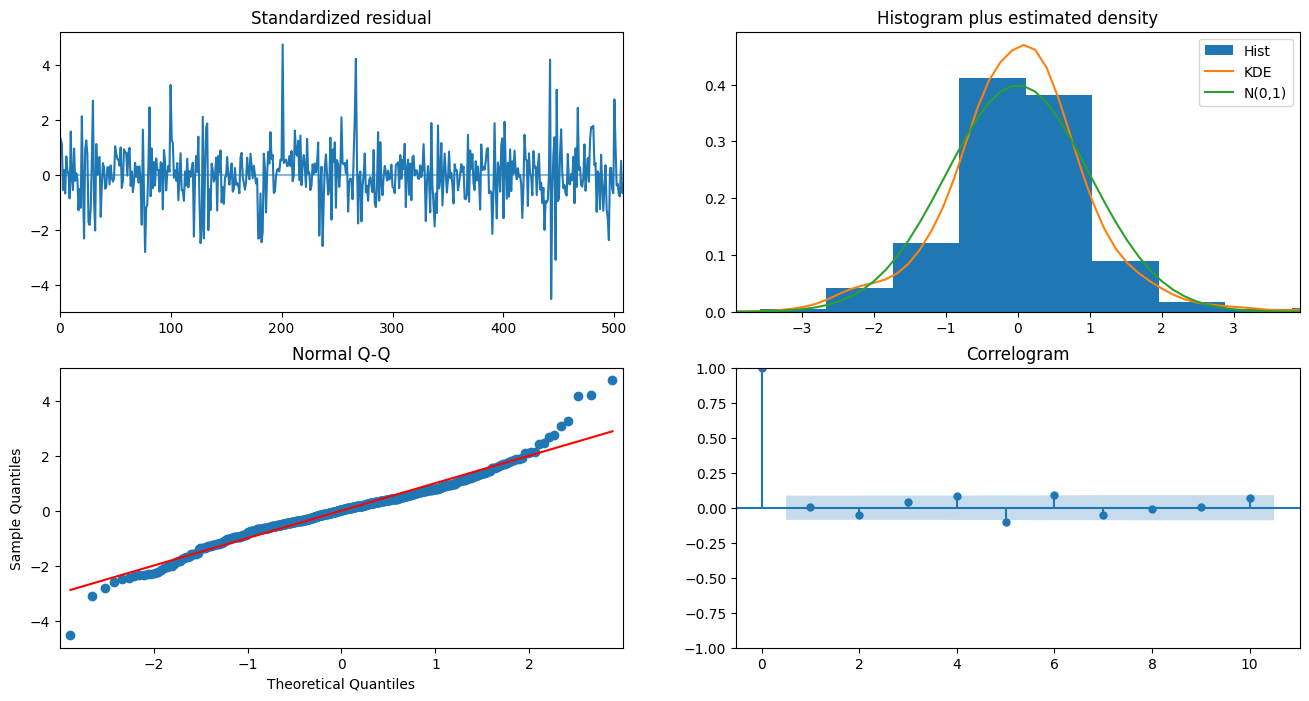

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

* Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

* Top Right: The density plot suggest normal distribution with mean zero.

* Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

* Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

### 5.1.4 LSTM
We will use a multi-layered LSTM (Long Short-Term Memory) recurrent neural network to predict the last value in a sequence of values.

Before building the LSTM model, we need to perform the following data pre-processing and feature engineering steps:

1. Create the Dataset: Ensure that all data values are converted to float.
2. Normalize the Features: Scale the features to a standard range (e.g., between 0 and 1) to improve model performance.
3. Split into Training and Test Sets: Divide the data into two sets: one for training the model and one for testing its performance.
4. Convert Values into a Dataset Matrix: Transform the array of values into a structured format suitable for modeling.
5. Reshape Data for Sequence Prediction:
* X = t: Features at time step t.
* Y = t+1: Target value at the next time step t+1.
6. Reshape Input to 3D: Format the input data into three dimensions: (num_samples, num_timesteps, num_features).

These steps will prepare the data for the LSTM model to effectively learn and make predictions.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
# Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [ ]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(x_train, y_train, batch_size=1, epochs=5,
          validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 19s 15ms/step - loss: 0.0093 - val_loss: 0.0016
Epoch 2/5
406/406 [==============================] - 5s 13ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 3/5
406/406 [==============================] - 3s 8ms/step - loss: 0.0024 - val_loss: 4.2133e-04
Epoch 4/5
406/406 [==============================] - 3s 7ms/step - loss: 0.0020 - val_loss: 4.7195e-04
Epoch 5/5
406/406 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            92672     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
            

In [ ]:
# Predict model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))


3/3 [==============================] - 0s 6ms/step
RMSE: 0.5031868496247538


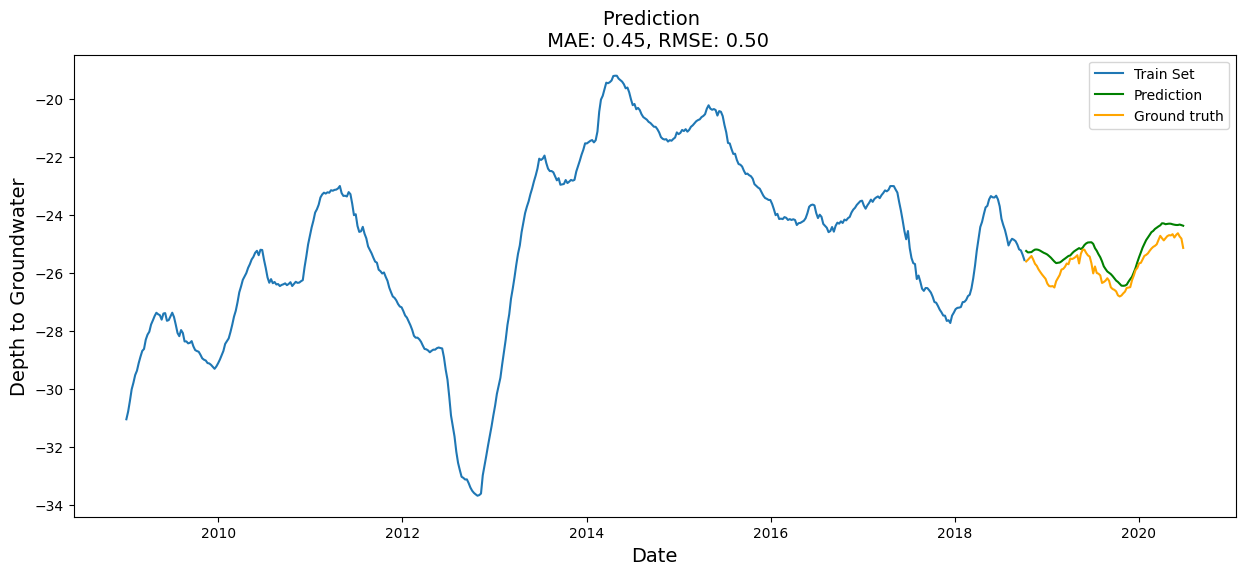

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

## Reference:
https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide